# Overview
I'll try to keep an up to date overview here of all methods I've tried so far.

## Table
Training set always contains NaNs (might be imputed), unless stated otherwise in the Notes column.

### Test set containing NaNs
(+/-x) where x is twice the standard deviation. If x is a question mark, cross validation wasn't used.
Note: about 60% of the rows contain NaNs.

| Method                                                                           | ROC               | Parameters       | Notes                                                                             | Notebook |
|----------------------------------------------------------------------------------|-------------------|------------------|-----------------------------------------------------------------------------------|----------|
| Random Forest                                                                    | 0.872 (+/- 0.020) |                  | If no imputation method metioned, then it's zero-imputed                          | 10, 111  |
| HistGradient                                                                     | 0.892 (+/- 0.011) |                  |                                                                                   | 10       |
| Random Forest (alpha-chain only)                                                 | 0.736 (+/-?)      | n_estimators=200 | Graph contains straight line (because of a lot of rows with the same value (NaN)) | 5        |
| Random Forest (beta-chain only)                                                  | 0.858 (+/-?)      | n_estimators=200 |                                                                                   | 5        |
| Random Forest (alpha and beta seperate RF models, combined with arithmetic mean) | 0.897 (+/-?)      | n_estimators=200 |                                                                                   | 5        |
| Random Forest (alpha and beta seperate RF models, combined with maximum)         | 0.890 (+/-?)      | n_estimators=200 |                                                                                   | 5        |
| Random Forest (alpha and beta seperate RF models, combined with minimum)         | 0.845 (+/-?)      | n_estimators=200 |                                                                                   | 5        |
| Random Forest (alpha and beta seperate RF models, combined with multiplication)  | 0.889 (+/-?)      | n_estimators=200 |                                                                                   | 5        |
| Random Forest (K-Means imputed)                                                  | 0.883 (+/-?)      |                  |                                                                                   | 7        |
| KNeighbors (K-Means imputed)                                                     | 0.781 (+/-?)      | n_neighbors=5    | Kinked ROC graph                                                                  | 7        |
| KNeighbors (Zero imputed)                                                        | 0.810 (+/-?)      | n_neighbors=5    | Kinked ROC graph                                                                  | 7        |
| KNeighbors (Mean imputed)                                                        | 0.807 (+/-?)      | n_neighbors=5    | Kinked ROC graph                                                                  | 7        |
| Random Forest (Mean imputed)                                                     | 0.870 (+/-0.021)  |                  |                                                                                   | 11       |
| Random Forest (Most frequent imputed)                                            | 0.871 (+/-0.018)  |                  |                                                                                   | 11       |
| Random Forest (Median imputed)                                                   | 0.869 (+/-0.019)  |                  |                                                                                   | 11       |
| Random Forest (Missing indicator, zero imputed)                                  | 0.874 (+/-0.016)  |                  |                                                                                   | 11       |

### Test set without NaNs
NaN's not dropped in train data unless mentioned otherwise. One model on both chains together, unless mentioned otherwise.

| Method                                                                           | ROC              | Parameters       | Notes                          | Notebook |
|----------------------------------------------------------------------------------|------------------|------------------|--------------------------------|----------|
| Random Forest (alpha-chain only)                                                 | 0.864 (+/-?)     | n_estimators=200 | NaNs also dropped in train set | 5        |
| Random Forest (beta-chain only)                                                  | 0.907 (+/-?)     | n_estimators=200 | NaNs also dropped in train set | 5        |
| Random Forest (alpha and beta seperate RF models, combined with arithmetic mean) | 0.934 (+/-?)     | n_estimators=200 | NaNs also dropped in train set | 5        |
| Random Forest (both-chains)                                                      | 0.926 (+/-?)     | n_estimators=200 | NaNs also dropped in train set | 5        |
| Random Forest (alpha-chain only)                                                 | 0.899 (+/-?)     | n_estimators=200 |                                | 5        |
| Random Forest (beta-chain only)                                                  | 0.933 (+/-?)     | n_estimators=200 |                                | 5        |
| Random Forest (alpha and beta seperate RF models, combined with arithmetic mean) | 0.963 (+/-?)     | n_estimators=200 |                                | 5        |
| Random Forest (both-chains)                                                      | 0.949 (+/-?)     | n_estimators=200 |                                | 5        |
| Random Forest (zero imputed)                                                     | 0.950 (+/-?)     |                  |                                | 11       |
| Random Forest (seperate models (mean combined), zero imputed)                    | 0.961 (+/-?)     |                  |                                | 11       |
| Random Forest (mean imputed)                                                     | 0.948 (+/-?)     |                  |                                | 11       |
| Random Forest (seperate models (mean combined), mean imputed)                    | 0.963 (+/-?)     |                  |                                | 11       |
| Random Forest (most freq imputed)                                                | 0.948 (+/-?)     |                  |                                | 11       |
| Random Forest (seperate models (mean combined), most freq imputed)               | 0.960 (+/-?)     |                  |                                | 11       |
| Random Forest (median imputed)                                                   | 0.950 (+/-?)     |                  |                                | 11       |
| Random Forest (seperate models (mean combined), median imputed)                  | 0.966 (+/-?)     |                  |                                | 11       |
| Random Forest (missing indicator, zero imputed)                                  | 0.953 (+/-?)     |                  |                                | 11       |
| HistGradient                                                                     | 0.891 (+/-0.013) |                  |                                | 10       |
| HistGradient (seperate chains)                                                   | 0.968 (+/-?)     |                  |                                | 10       |


## Separatly
In notebook 5, we've trained a model (Random Forest) on the alpha-chain and a different model (also Random Forest) on the beta-chain.

## Data and Features

In [1]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from util import get_train_dataset, get_features, fix_test
import numpy as np

df = get_train_dataset()
# df = df.sample(n=1000)

df_reaction_column = df['reaction']
df_features = get_features(df)

df_features.reset_index(drop=True, inplace=True)
df_reaction_column.reset_index(drop=True, inplace=True)

assert df_features.shape[0] == df_reaction_column.shape[0]
assert np.isnan(df_reaction_column).sum().sum() == 0

# add the reaction column to the features (will be dropped later on)
df_features['reaction'] = df_reaction_column

In [2]:
y = df_features['reaction']
x = df_features.drop(['reaction'], axis=1)

assert 'reaction' not in x.columns
assert np.isnan(y).sum() == 0

## Edited data
Some models require the data to be edited in a certain way. This is done here.

In [3]:
# replace nan values with 0
x_zero_filled = x.fillna(0)
assert np.isnan(x_zero_filled).sum().sum() == 0

## Util

In [4]:
def evaluate(clf):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, x_zero_filled, y, cv=kf, scoring='roc_auc')
    print(scores)
    print(f"ROC: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")

## Random Forest

In [5]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0)
evaluate(clf)

[0.88498462 0.88172472 0.85801867 0.87094258 0.86453068]
ROC: 0.872 (+/- 0.020)


## Hist Gradient Boosting

In [6]:
from sklearn.ensemble import HistGradientBoostingClassifier
clf = HistGradientBoostingClassifier(random_state=0)
evaluate(clf)

[0.89563107 0.89998001 0.88828785 0.89254687 0.88447752]
ROC: 0.892 (+/- 0.011)


# Test without NaNs

In [3]:
from sklearn.model_selection import train_test_split
from util import get_train_dataset, get_features, fix_test, evaluate, calculate_auc_and_plot, get_columns_starting_with

df = get_train_dataset()
# df = df.sample(n=1000) # for faster debugging

train, test = train_test_split(df, test_size=0.2, random_state=42)

test.dropna(inplace=True)
x = get_features(train)
y = train['reaction']
x_test = get_features(test, test=True)
x_test = fix_test(x_test, x.columns)
y_test = test['reaction']

C:\Users\arnod\PycharmProjects\thesis\util\classification.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = np.nan  # TODO: NaN geven


In [8]:
cv_x = get_features(df)
cv_y = df['reaction']

In [4]:
def evaluate_seperate_chains(clf1, clf2):
    # Keep only the columns starting with 'alfa_'
    x_alpha = get_columns_starting_with(x, 'alfa_')
    x_beta = get_columns_starting_with(x, 'beta_')

    clf1.fit(x_alpha, y)
    clf2.fit(x_beta, y)

    x_test_alpha = get_columns_starting_with(x_test, 'alfa_')
    x_test_beta = get_columns_starting_with(x_test, 'beta_')

    x_test_alpha = fix_test(x_test_alpha, x_alpha.columns)
    x_test_beta = fix_test(x_test_beta, x_beta.columns)

    y_pred1 = clf1.predict_proba(x_test_alpha)[:, 1]
    y_pred2 = clf2.predict_proba(x_test_beta)[:, 1]

    y_pred = (y_pred1 + y_pred2) / 2
    auc = calculate_auc_and_plot(y_test, y_pred)

    print(f'AUC: {auc:.3f}')

## Hist Gradient Boosting

In [5]:
from sklearn.ensemble import HistGradientBoostingClassifier
clf = HistGradientBoostingClassifier(random_state=0)

In [6]:
evaluate(clf, x, y)

[0.87931909 0.87896632 0.8853386  0.8901665  0.88618256]
ROC: 0.884 (+/- 0.009)


In [9]:
evaluate(clf, cv_x, cv_y)

[0.89843189 0.89649854 0.88177803 0.89522621 0.88509522]
ROC: 0.891 (+/- 0.013)


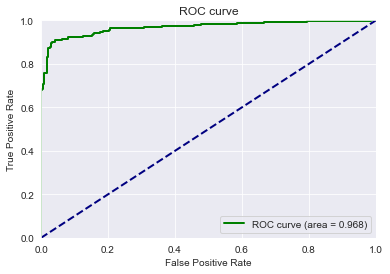

AUC: 0.968


In [7]:
clf2 = HistGradientBoostingClassifier(random_state=0)
evaluate_seperate_chains(clf, clf2)

gen family en soort opsplitsen
histgradient op test zonder nan -> OK
andere imputations bij RF -> OK
Kijken meer datasets? uitleggen hoe je da zelf moet doenvdjdbgithub link, lijst met rleases, latest 30/3, zip, vdjdb-full, column antign epitope, kan je doen voo randere pitopen,  een dataset die ik best verwijder, gewoon erin latn
datasets voor epitope werken, elke andere epitope kan werken voor een negative (cross reactieve er wel uithalen)